In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.auto import tqdm

from scripts.utils import ScaleData, train_keys, target_keys

In [2]:
torch.set_default_dtype(torch.float32)

class ITG_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        X = self.model(x)
        return X

class ITG_Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),

        )

    def forward(self, x):
        X = self.model(x.float())
        return X

class ITGDataset(Dataset):
    def __init__(self, X, y, z = None):
        self.X = X
        self.y = y
        self.z = z

    # number of rows in the dataset
    def __len__(self):
        return len(self.y)

    # get a row at an index
    def __getitem__(self, idx):
        if self.z is not None:
            return[self.X[idx], self.y[idx], self.z[idx]]
        else:
            return [self.X[idx], self.y[idx]]

    # add method to add a new row to the dataset
    def add(self, x, y, z = None):
        self.X = np.append(self.X, x, axis = 0)
        self.y = np.append(self.y, y, axis = 0)
        
        if z is not None:
            self.z = np.append(self.z, z, axis = 0)


In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    losses = []
    correct = 0
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y.unsqueeze(-1).float())

        pred_class = torch.round(pred.squeeze())
        correct += torch.sum(pred_class == y.float()).item()


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss
        losses.append(loss.item())
    correct /= size
    avg_loss = np.mean(losses)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return avg_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, z in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y.unsqueeze(-1).float()).item()
            # calculate test accuracy
            pred_class = torch.round(pred.squeeze())
            correct += torch.sum(pred_class == y.float()).item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



def regression_train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    losses = []
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, z.float())

        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = np.mean(losses)
    print(f"Train Error: \nAvg loss: {avg_loss:>4f}")
    return avg_loss

def regression_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, z in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, z.float()).item()

    test_loss /= num_batches
    print(f"Test Error: \nAvg loss: {test_loss:>4f} \n")
    return test_loss

In [5]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

# Keep only the data that gives an output
train_data = train_data[train_data["target"] == 1]
validation_data = validation_data[validation_data["target"] == 1]


In [6]:
keep_keys = train_keys + ["efiitg_gb", "efeetg_gb", "efetem_gb"]

train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys].sample(100_000)

train_data = train_data.dropna()
validation_data = validation_data.dropna()

train_data['itg'] = np.where(train_data['efiitg_gb'] != 0, 1, 0)
validation_data['itg'] = np.where(validation_data['efiitg_gb'] != 0, 1, 0)

train_data['etg'] = np.where(train_data['efeetg_gb'] != 0, 1, 0)
validation_data['etg'] = np.where(validation_data['efeetg_gb'] != 0, 1, 0)

train_data['tem'] = np.where(train_data['efetem_gb'] != 0, 1, 0)
validation_data['tem'] = np.where(validation_data['efetem_gb'] != 0, 1, 0)


In [7]:
def get_loaders(flux, flux_class, training_data, validation_data, train_keys = train_keys):

        x_train = training_data[train_keys].to_numpy()
        y_train_class = training_data[flux_class].to_numpy()
        y_train_reg = training_data[flux].to_numpy()

        x_valid = validation_data[train_keys].to_numpy()
        y_valid_class = validation_data[flux_class].to_numpy()
        y_valid_reg = validation_data[flux].to_numpy()

        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_valid = scaler.transform(x_valid)

        scaler_reg = StandardScaler()
        scaler_reg.fit(y_train_reg.reshape(-1, 1))
        y_train_reg = scaler_reg.transform(y_train_reg.reshape(-1, 1))
        y_valid_reg = scaler_reg.transform(y_valid_reg.reshape(-1, 1))

        train_dataset = ITGDataset(x_train, y_train_class, y_train_reg)
        valid_dataset = ITGDataset(x_valid, y_valid_class, y_valid_reg)

        train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle = True)
        valid_loader = DataLoader(valid_dataset, batch_size = 1024, shuffle = True)

        return train_loader, valid_loader
        

In [16]:
def train_model(
    train_loader,
    valid_loader,
    class_epochs = 50,
    reg_epochs = 75,
    classifier = ITG_Classifier,
    regressor = ITG_Regressor,
    regressor_only = False
    ):
    
    classifier = classifier()

    learning_rate = 1e-3
    
    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    
    if not regressor_only:
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

        print("Training Classifier")
        for epoch in range(class_epochs):
            avg_loss, avg_acc = train_loop(train_loader, classifier, loss_fn, optimizer)
            train_losses.append(avg_loss)
            train_accs.append(avg_acc)

            avg_loss, avg_acc = test_loop(valid_loader, classifier, loss_fn)
            valid_losses.append(avg_loss)
            valid_accs.append(avg_acc)

            print(f"Epoch {epoch+1}/{class_epochs} \n")

    regressor = regressor()
    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(regressor.parameters(), lr=learning_rate, weight_decay=1e-4)

    reg_train_losses = []
    reg_valid_losses = []
    print("Training Regressor")
    for epoch in range(reg_epochs):
        avg_loss = regression_train_loop(train_loader, regressor, loss_fn, optimizer)
        reg_train_losses.append(avg_loss)

        avg_loss = regression_test_loop(valid_loader, regressor, loss_fn)
        reg_valid_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{reg_epochs} \n")

    return classifier, regressor, [train_losses, train_accs, valid_losses, valid_accs, reg_train_losses, reg_valid_losses]


In [57]:
#train_data_10K = train_data.sample(10_000)

#train_data_10K.to_pickle("/unix/atlastracking/jbarr/UKAEAGroupProject/models/train_data_10K.pkl")

# load the data
train_data_10K = pd.read_pickle("/unix/atlastracking/jbarr/UKAEAGroupProject/models/train_data_10K.pkl")

In [58]:
itg_train_loader, itg_valid_loader = get_loaders(
    "efiitg_gb", 
    "itg", 
    train_data_10K, 
    validation_data 
)

In [61]:
itg_class, itg_reg, itg_losses = train_model(itg_train_loader, itg_valid_loader)

Training Classifier
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.614946 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.550531 

Epoch 1/50 

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.499437 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.467166 

Epoch 2/50 

Train Error: 
 Accuracy: 74.5%, Avg loss: 0.432246 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.416739 

Epoch 3/50 

Train Error: 
 Accuracy: 77.3%, Avg loss: 0.391728 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.381321 

Epoch 4/50 

Train Error: 
 Accuracy: 82.7%, Avg loss: 0.356061 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.345322 

Epoch 5/50 

Train Error: 
 Accuracy: 86.7%, Avg loss: 0.318592 

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.314955 

Epoch 6/50 

Train Error: 
 Accuracy: 88.2%, Avg loss: 0.290118 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.287401 

Epoch 7/50 

Train Error: 
 Accuracy: 89.0%, Avg loss: 0.261301 

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.259743 

Epoch 8/50 

Train Error: 
 Accuracy: 90.1%, Avg 

In [62]:
# save the model
# torch.save(itg_class.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_10K.pt")
# torch.save(itg_reg.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_10K.pt")

Text(0.5, 1.0, 'ITG Regression Loss')

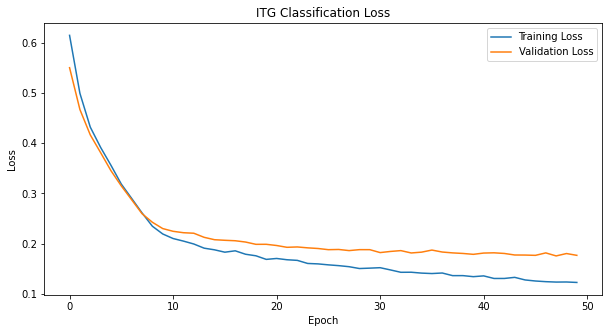

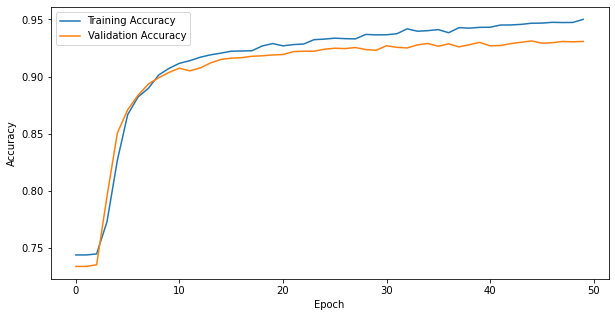

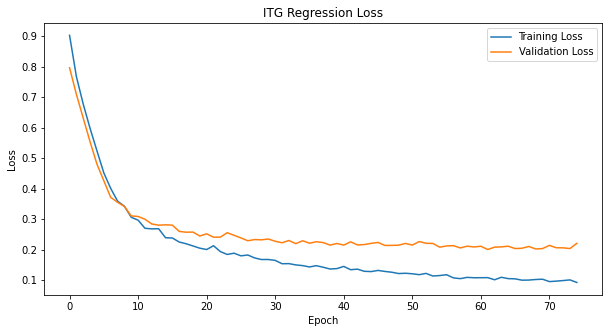

In [65]:
train_loss, train_acc, valid_loss, valid_acc, reg_train_loss, reg_valid_loss = itg_losses

plt.figure(figsize=(10,5))
plt.plot(train_loss, label = "Training Loss")
plt.plot(valid_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label = "Training Accuracy")
plt.plot(valid_acc, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(reg_train_loss, label = "Training Loss")
plt.plot(reg_valid_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Regression Loss")

In [72]:
# train on etg data
etg_train_loader, etg_valid_loader = get_loaders(
    "efeetg_gb", 
    "etg", 
    train_data_10K, 
    validation_data 
)

etg_class, etg_reg, etg_losses = train_model(etg_train_loader, etg_valid_loader, class_epochs = 75, reg_epochs = 500)

Training Classifier
Train Error: 
 Accuracy: 82.4%, Avg loss: 0.576066 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.461890 

Epoch 1/75 

Train Error: 
 Accuracy: 83.9%, Avg loss: 0.408208 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.381191 

Epoch 2/75 

Train Error: 
 Accuracy: 83.9%, Avg loss: 0.337601 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.324692 

Epoch 3/75 

Train Error: 
 Accuracy: 83.9%, Avg loss: 0.301909 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.290988 

Epoch 4/75 

Train Error: 
 Accuracy: 84.3%, Avg loss: 0.268024 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.259583 

Epoch 5/75 

Train Error: 
 Accuracy: 88.2%, Avg loss: 0.236811 

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.228123 

Epoch 6/75 

Train Error: 
 Accuracy: 90.8%, Avg loss: 0.208431 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.203895 

Epoch 7/75 

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.185797 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.186398 

Epoch 8/75 

Train Error: 
 Accuracy: 92.9%, Avg 

Text(0.5, 1.0, 'ETG Regression Loss')

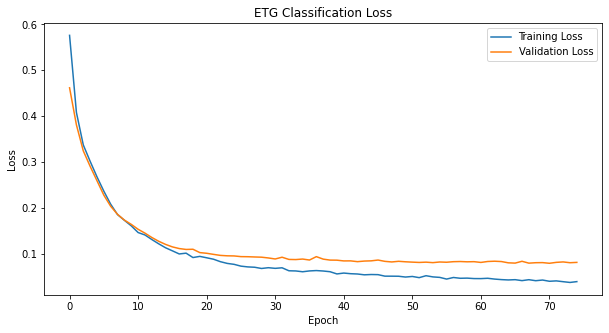

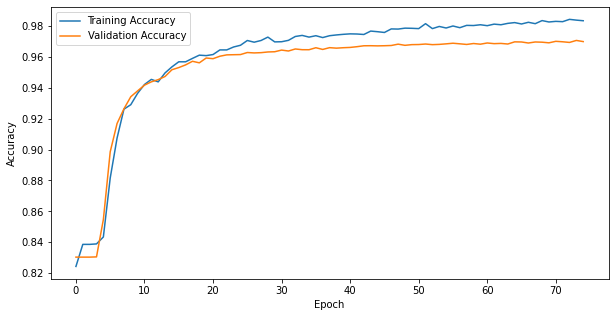

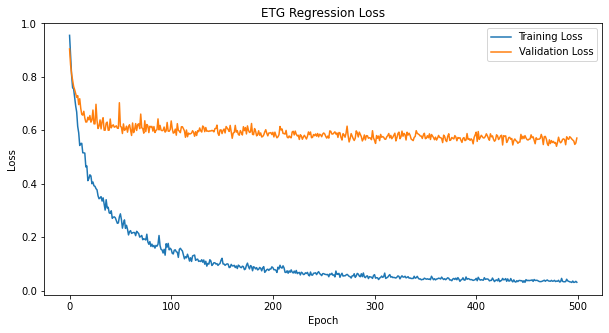

In [73]:
etg_train_loss, etg_train_acc, etg_valid_loss, etg_valid_acc, etg_reg_train_loss, etg_reg_valid_loss = etg_losses

plt.figure(figsize=(10,5))
plt.plot(etg_train_loss, label = "Training Loss")
plt.plot(etg_valid_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc, label = "Training Accuracy")
plt.plot(etg_valid_acc, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss, label = "Training Loss")
plt.plot(etg_reg_valid_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")

In [74]:
# save the models
torch.save(etg_class.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_10K.pt")
torch.save(etg_reg.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_10K.pt")

In [75]:

tem_train_loader, tem_valid_loader = get_loaders(
    "efetem_gb", 
    "tem", 
    train_data_10K, 
    validation_data 
)

tem_class, tem_reg, tem_losses = train_model(tem_train_loader, tem_valid_loader, class_epochs = 75, reg_epochs = 500)

Training Classifier
Train Error: 
 Accuracy: 79.0%, Avg loss: 0.589501 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.432670 

Epoch 1/75 

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.356375 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.296679 

Epoch 2/75 

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.274081 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.236841 

Epoch 3/75 

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.237739 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.217360 

Epoch 4/75 

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.215978 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.199107 

Epoch 5/75 

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.197198 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.183697 

Epoch 6/75 

Train Error: 
 Accuracy: 91.8%, Avg loss: 0.181142 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.167895 

Epoch 7/75 

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.165179 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.157613 

Epoch 8/75 

Train Error: 
 Accuracy: 93.5%, Avg 

Text(0.5, 1.0, 'TEM Regression Loss')

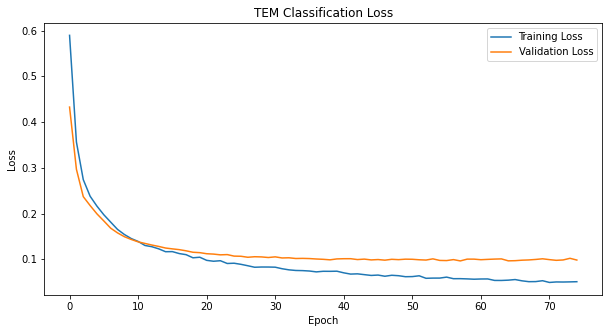

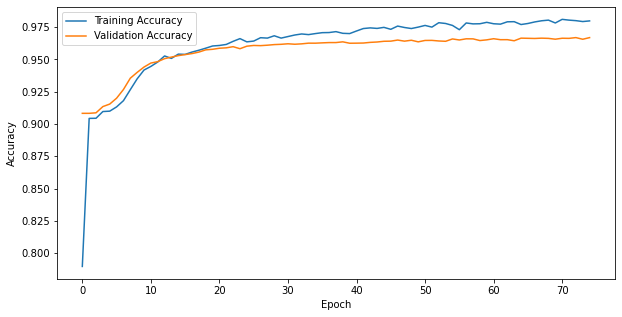

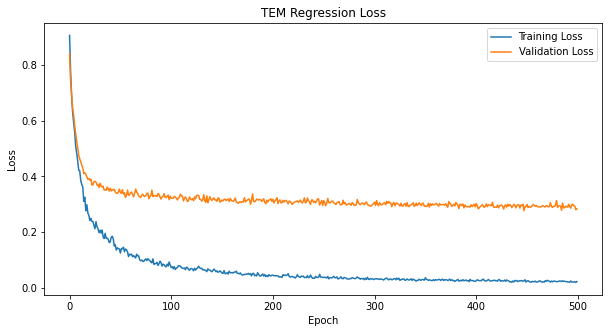

In [76]:
tem_train_loss, tem_train_acc, tem_valid_loss, tem_valid_acc, tem_reg_train_loss, tem_reg_valid_loss = tem_losses

plt.figure(figsize=(10,5))
plt.plot(tem_train_loss, label = "Training Loss")
plt.plot(tem_valid_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(tem_train_acc, label = "Training Accuracy")
plt.plot(tem_valid_acc, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(tem_reg_train_loss, label = "Training Loss")
plt.plot(tem_reg_valid_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Regression Loss")

In [77]:
# save the models
#torch.save(tem_class.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_10K.pt")
#torch.save(tem_reg.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_10K.pt")

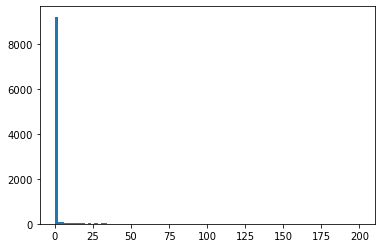

In [55]:
# plot "efeetg_gb" distribution
plt.figure()

plt.hist(train_data_10K["efetem_gb"], bins = 100);

In [78]:
# repeat with 20K
#train_data_20K = train_data.sample(20_000)

#train_data_20K.to_pickle("/unix/atlastracking/jbarr/UKAEAGroupProject/models/train_data_20K.pkl")

train_data_20K = pd.read_pickle("/unix/atlastracking/jbarr/UKAEAGroupProject/models/train_data_20K.pkl")


In [81]:
itg_train_loader_20K, itg_valid_loader_20K = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_20K,
    validation_data
)

itg_class_20K, itg_reg_20K, itg_losses_20K = train_model(itg_train_loader_20K, itg_valid_loader_20K)

Training Classifier
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.560106 

Test Error: 
 Accuracy: 74.7%, Avg loss: 0.452925 

Epoch 1/50 

Train Error: 
 Accuracy: 79.8%, Avg loss: 0.402499 

Test Error: 
 Accuracy: 84.7%, Avg loss: 0.353465 

Epoch 2/50 

Train Error: 
 Accuracy: 86.8%, Avg loss: 0.318863 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.283364 

Epoch 3/50 

Train Error: 
 Accuracy: 89.1%, Avg loss: 0.260576 

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.243265 

Epoch 4/50 

Train Error: 
 Accuracy: 90.3%, Avg loss: 0.229170 

Test Error: 
 Accuracy: 90.7%, Avg loss: 0.221942 

Epoch 5/50 

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.213019 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.209405 

Epoch 6/50 

Train Error: 
 Accuracy: 91.6%, Avg loss: 0.201274 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.204338 

Epoch 7/50 

Train Error: 
 Accuracy: 91.6%, Avg loss: 0.199285 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.196312 

Epoch 8/50 

Train Error: 
 Accuracy: 92.1%, Avg 

Text(0.5, 1.0, 'ITG Regression Loss')

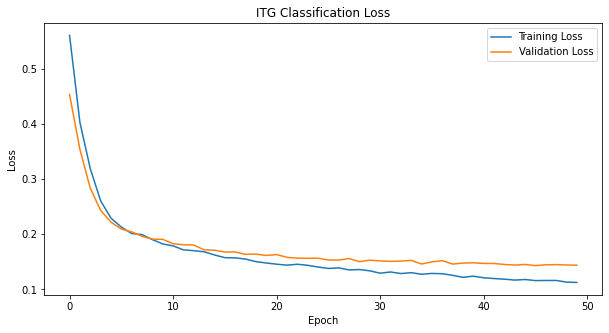

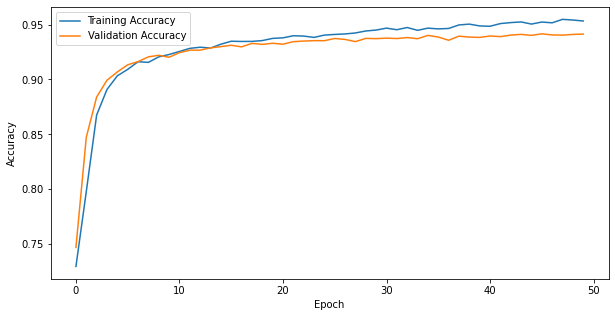

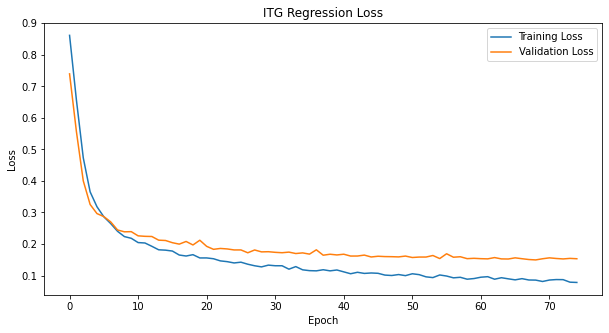

In [82]:
itg_train_loss_20K, itg_train_acc_20K, itg_valid_loss_20K, itg_valid_acc_20K, itg_reg_train_loss_20K, itg_reg_valid_loss_20K = itg_losses_20K

plt.figure(figsize=(10,5))
plt.plot(itg_train_loss_20K, label = "Training Loss")
plt.plot(itg_valid_loss_20K, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(itg_train_acc_20K, label = "Training Accuracy")
plt.plot(itg_valid_acc_20K, label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(itg_reg_train_loss_20K, label = "Training Loss")
plt.plot(itg_reg_valid_loss_20K, label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Regression Loss")

In [83]:
# save the models
torch.save(itg_class_20K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_20K.pt")
torch.save(itg_reg_20K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_20K.pt")

In [88]:
etg_train_loader_20K, etg_valid_loader_20K = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_20K,
    validation_data
)

etg_class_20K, etg_reg_20K, etg_losses_20K = train_model(etg_train_loader_20K, etg_valid_loader_20K, class_epochs = 75, reg_epochs = 500)

Training Classifier
Train Error: 
 Accuracy: 78.5%, Avg loss: 0.514251 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.384094 

Epoch 1/75 

Train Error: 
 Accuracy: 82.8%, Avg loss: 0.340098 

Test Error: 
 Accuracy: 83.1%, Avg loss: 0.303886 

Epoch 2/75 

Train Error: 
 Accuracy: 84.5%, Avg loss: 0.273393 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.240254 

Epoch 3/75 

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.214391 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.192926 

Epoch 4/75 

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.178165 

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.169735 

Epoch 5/75 

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.159533 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.151265 

Epoch 6/75 

Train Error: 
 Accuracy: 94.3%, Avg loss: 0.139447 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.133454 

Epoch 7/75 

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.121530 

Test Error: 
 Accuracy: 95.2%, Avg loss: 0.117647 

Epoch 8/75 

Train Error: 
 Accuracy: 95.6%, Avg 

Text(0.5, 1.0, 'ETG Regression Loss')

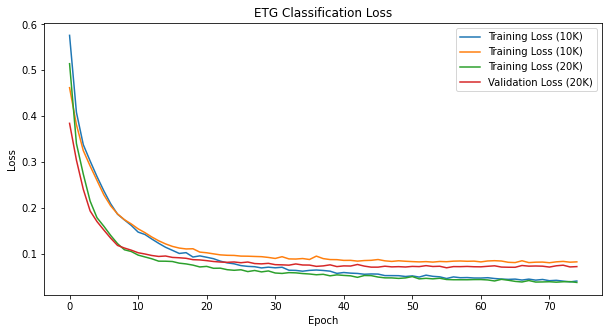

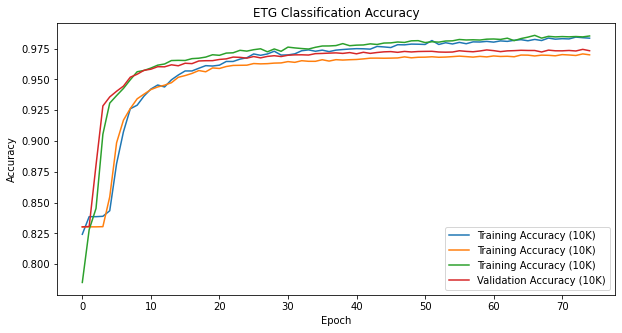

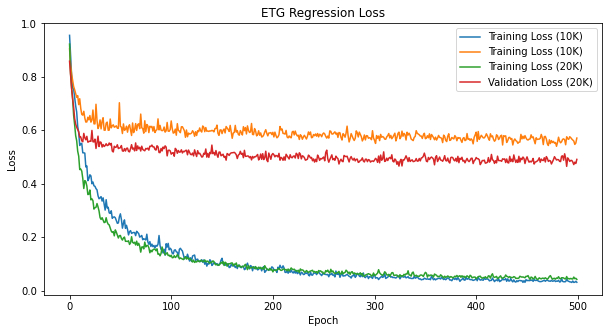

In [ ]:
etg_train_loss_20K, etg_train_acc_20K, etg_valid_loss_20K, etg_valid_acc_20K, etg_reg_train_loss_20K, etg_reg_valid_loss_20K = etg_losses_20K

plt.figure(figsize=(10,5))
plt.plot(etg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_valid_loss, label = "Validation Loss (10K)")
plt.plot(etg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(etg_valid_loss_20K, label = "Validation Loss (20K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc_20K, label = "Training Accuracy (20K)")
plt.plot(etg_valid_acc_20K, label = "Validation Accuracy (20K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ETG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(etg_reg_valid_loss_20K, label = "Validation Loss (20K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")

In [90]:
# save the models
torch.save(etg_class_20K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_20K.pt")
torch.save(etg_reg_20K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_20K.pt")

In [91]:
tem_train_loader_20K, tem_valid_loader_20K = get_loaders(
    "efetem_gb",
    "tem",
    train_data_20K,
    validation_data
)

tem_class_20K, tem_reg_20K, tem_losses_20K = train_model(tem_train_loader_20K, tem_valid_loader_20K, class_epochs = 75, reg_epochs = 500)

Training Classifier
Train Error: 
 Accuracy: 88.4%, Avg loss: 0.473245 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.309166 

Epoch 1/75 

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.263818 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.225880 

Epoch 2/75 

Train Error: 
 Accuracy: 90.7%, Avg loss: 0.218209 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.191970 

Epoch 3/75 

Train Error: 
 Accuracy: 91.6%, Avg loss: 0.185744 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.165150 

Epoch 4/75 

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.161224 

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.147754 

Epoch 5/75 

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.146696 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.137372 

Epoch 6/75 

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.135121 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.129901 

Epoch 7/75 

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.126223 

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.123029 

Epoch 8/75 

Train Error: 
 Accuracy: 95.4%, Avg 

Text(0.5, 1.0, 'TEM Regression Loss')

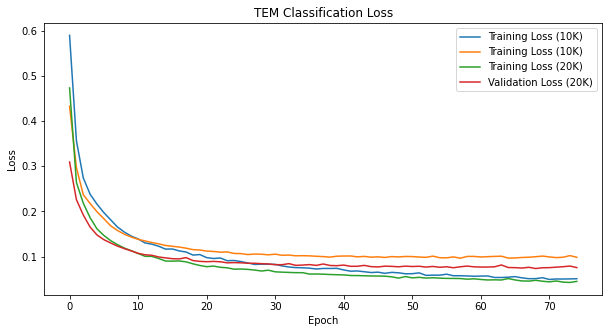

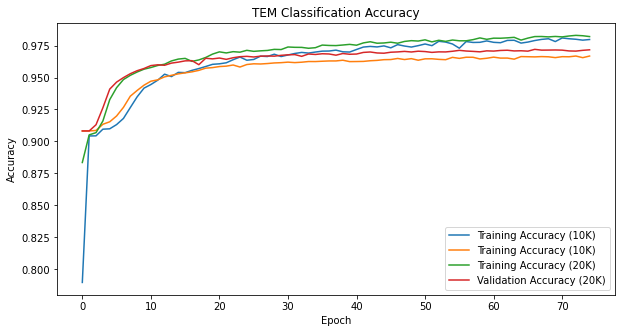

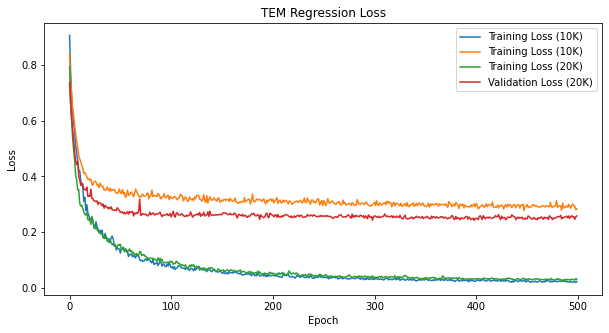

In [ ]:
tem_train_loss_20K, tem_train_acc_20K, tem_valid_loss_20K, tem_valid_acc_20K, tem_reg_train_loss_20K, tem_reg_valid_loss_20K = tem_losses_20K

plt.figure(figsize=(10,5))
plt.plot(tem_train_loss, label = "Training Loss (10K)")
plt.plot(tem_valid_loss, label = "Validation Loss (10K)")
plt.plot(tem_train_loss_20K, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K, label = "Validation Loss (20K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(tem_train_acc, label = "Training Accuracy (10K)")
plt.plot(tem_valid_acc, label = "Validation Accuracy (10K)")
plt.plot(tem_train_acc_20K, label = "Training Accuracy (20K)")
plt.plot(tem_valid_acc_20K, label = "Validation Accuracy (20K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("TEM Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(tem_reg_train_loss, label = "Training Loss (10K)")
plt.plot(tem_reg_valid_loss, label = "Validation Loss (10K)")
plt.plot(tem_reg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K, label = "Validation Loss (20K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Regression Loss")

In [93]:
# save the models
torch.save(tem_class_20K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_20K.pt")
torch.save(tem_reg_20K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_20K.pt")

#### Repeat with 50K

In [96]:
#train_data_50K = train_data.sample(50_000)
#train_data_50K.to_pickle("/unix/atlastracking/jbarr/UKAEAGroupProject/models/train_data_50K.pkl")

train_data_50K = pd.read_pickle("/unix/atlastracking/jbarr/UKAEAGroupProject/models/train_data_50K.pkl")

In [97]:
itg_train_loader_50K, itg_valid_loader_50K = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_50K,
    validation_data
)

itg_class_50K, itg_reg_50K, itg_losses_50K = train_model(itg_train_loader_50K, itg_valid_loader_50K)

Training Classifier
Train Error: 
 Accuracy: 78.0%, Avg loss: 0.451211 

Test Error: 
 Accuracy: 87.6%, Avg loss: 0.312958 

Epoch 1/50 

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.256015 

Test Error: 
 Accuracy: 90.7%, Avg loss: 0.220787 

Epoch 2/50 

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.208985 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.201515 

Epoch 3/50 

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.190632 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.186331 

Epoch 4/50 

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.179585 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.174663 

Epoch 5/50 

Train Error: 
 Accuracy: 92.8%, Avg loss: 0.170638 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.168629 

Epoch 6/50 

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.163897 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.162217 

Epoch 7/50 

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.157695 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.160078 

Epoch 8/50 

Train Error: 
 Accuracy: 93.4%, Avg 

Text(0.5, 1.0, 'ITG Regression Loss')

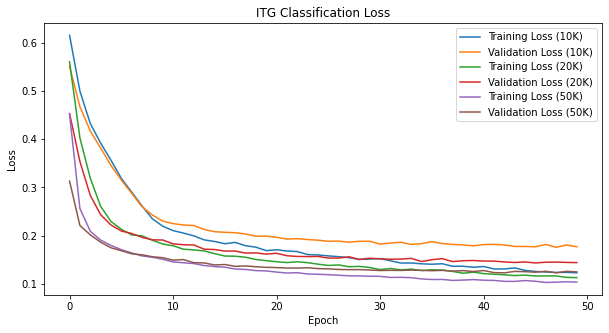

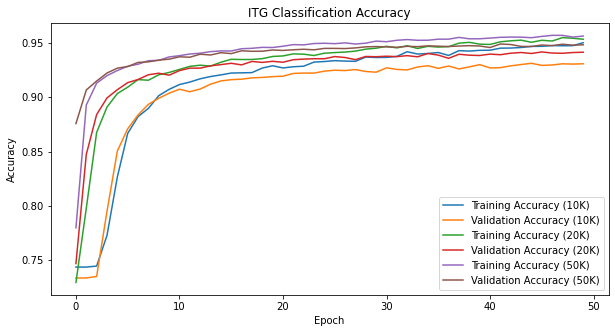

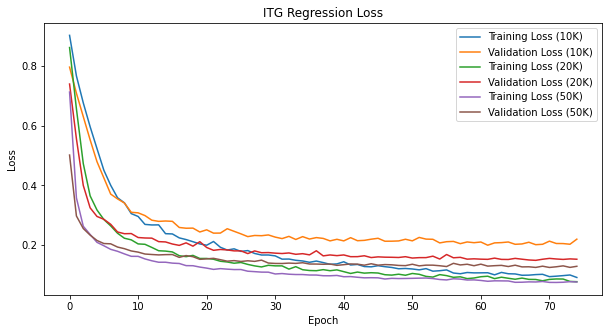

In [102]:
itg_train_loss_50K, itg_train_acc_50K, itg_valid_loss_50K, itg_valid_acc_50K, itg_reg_train_loss_50K, itg_reg_valid_loss_50K = itg_losses_50K

plt.figure(figsize=(10,5))
plt.plot(train_loss, label = "Training Loss (10K)")
plt.plot(valid_loss, label = "Validation Loss (10K)")
plt.plot(itg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(itg_valid_loss_20K, label = "Validation Loss (20K)")
plt.plot(itg_train_loss_50K, label = "Training Loss (50K)")
plt.plot(itg_valid_loss_50K, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label = "Training Accuracy (10K)")
plt.plot(valid_acc, label = "Validation Accuracy (10K)")
plt.plot(itg_train_acc_20K, label = "Training Accuracy (20K)")
plt.plot(itg_valid_acc_20K, label = "Validation Accuracy (20K)")
plt.plot(itg_train_acc_50K, label = "Training Accuracy (50K)")
plt.plot(itg_valid_acc_50K, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ITG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(reg_train_loss, label = "Training Loss (10K)")
plt.plot(reg_valid_loss, label = "Validation Loss (10K)")
plt.plot(itg_reg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(itg_reg_valid_loss_20K, label = "Validation Loss (20K)")
plt.plot(itg_reg_train_loss_50K, label = "Training Loss (50K)")
plt.plot(itg_reg_valid_loss_50K, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Regression Loss")

In [99]:
# save the models
torch.save(itg_class_50K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_50K.pt")
torch.save(itg_reg_50K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_50K.pt")

In [104]:
etg_train_loader_50K, etg_valid_loader_50K = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_50K,
    validation_data
)

etg_class_50K, etg_reg_50K, etg_losses_50K = train_model(etg_train_loader_50K, etg_valid_loader_50K, class_epochs=75, reg_epochs=500)

Training Classifier
Train Error: 
 Accuracy: 83.0%, Avg loss: 0.410414 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.283836 

Epoch 1/75 

Train Error: 
 Accuracy: 89.1%, Avg loss: 0.219776 

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.179800 

Epoch 2/75 

Train Error: 
 Accuracy: 94.1%, Avg loss: 0.145800 

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.119541 

Epoch 3/75 

Train Error: 
 Accuracy: 95.4%, Avg loss: 0.110672 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.107801 

Epoch 4/75 

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.097069 

Test Error: 
 Accuracy: 96.1%, Avg loss: 0.093357 

Epoch 5/75 

Train Error: 
 Accuracy: 96.3%, Avg loss: 0.088541 

Test Error: 
 Accuracy: 96.4%, Avg loss: 0.086836 

Epoch 6/75 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.083547 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.083055 

Epoch 7/75 

Train Error: 
 Accuracy: 96.8%, Avg loss: 0.078271 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.082312 

Epoch 8/75 

Train Error: 
 Accuracy: 96.9%, Avg 

Text(0.5, 1.0, 'ETG Regression Loss')

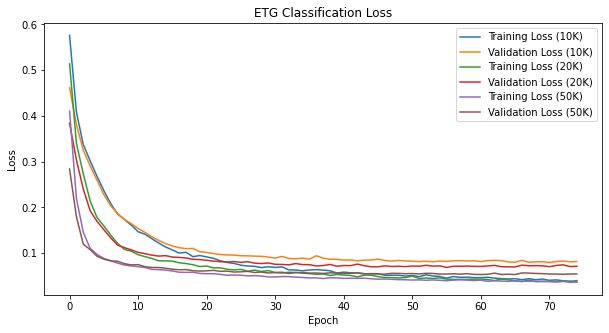

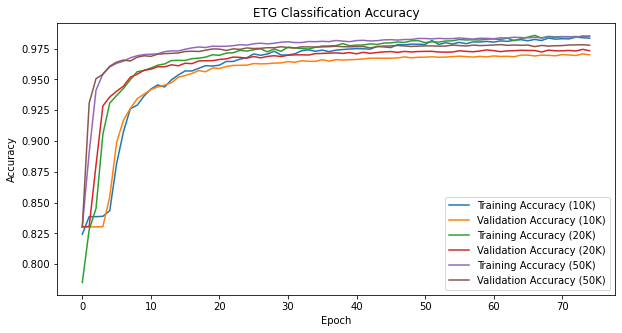

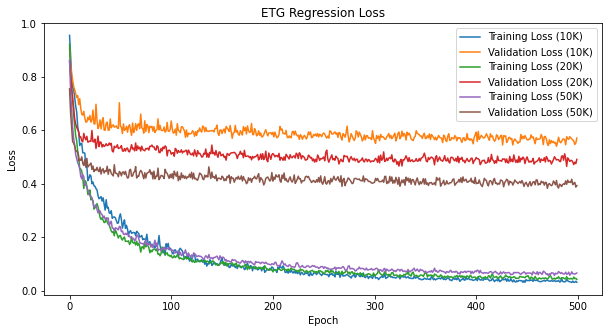

In [106]:
etg_train_loss_50K, etg_train_acc_50K, etg_valid_loss_50K, etg_valid_acc_50K, etg_reg_train_loss_50K, etg_reg_valid_loss_50K = etg_losses_50K

plt.figure(figsize=(10,5))
plt.plot(etg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_valid_loss, label = "Validation Loss (10K)")
plt.plot(etg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(etg_valid_loss_20K, label = "Validation Loss (20K)")
plt.plot(etg_train_loss_50K, label = "Training Loss (50K)")
plt.plot(etg_valid_loss_50K, label = "Validation Loss (50K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc_20K, label = "Training Accuracy (20K)")
plt.plot(etg_valid_acc_20K, label = "Validation Accuracy (20K)")
plt.plot(etg_train_acc_50K, label = "Training Accuracy (50K)")
plt.plot(etg_valid_acc_50K, label = "Validation Accuracy (50K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ETG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(etg_reg_valid_loss_20K, label = "Validation Loss (20K)")
plt.plot(etg_reg_train_loss_50K, label = "Training Loss (50K)")
plt.plot(etg_reg_valid_loss_50K, label = "Validation Loss (50K)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")

In [108]:
# save the models
torch.save(etg_class_50K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_50K.pt")
torch.save(etg_reg_50K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_50K.pt")

In [109]:
tem_train_loader_50K, tem_valid_loader_50K = get_loaders(
    "efetem_gb",
    "tem",
    train_data_50K,
    validation_data
)

tem_class_50K, tem_reg_50K, tem_losses_50K = train_model(tem_train_loader_50K, tem_valid_loader_50K, class_epochs=75, reg_epochs=500)

Training Classifier
Train Error: 
 Accuracy: 90.2%, Avg loss: 0.336412 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.202454 

Epoch 1/75 

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.173206 

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.147454 

Epoch 2/75 

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.137222 

Test Error: 
 Accuracy: 95.2%, Avg loss: 0.123545 

Epoch 3/75 

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.119271 

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.111193 

Epoch 4/75 

Train Error: 
 Accuracy: 95.9%, Avg loss: 0.103867 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.099696 

Epoch 5/75 

Train Error: 
 Accuracy: 96.1%, Avg loss: 0.098683 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.098266 

Epoch 6/75 

Train Error: 
 Accuracy: 96.3%, Avg loss: 0.091598 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.088491 

Epoch 7/75 

Train Error: 
 Accuracy: 96.6%, Avg loss: 0.085385 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.086200 

Epoch 8/75 

Train Error: 
 Accuracy: 96.7%, Avg 

Text(0.5, 1.0, 'TEM Regression Loss')

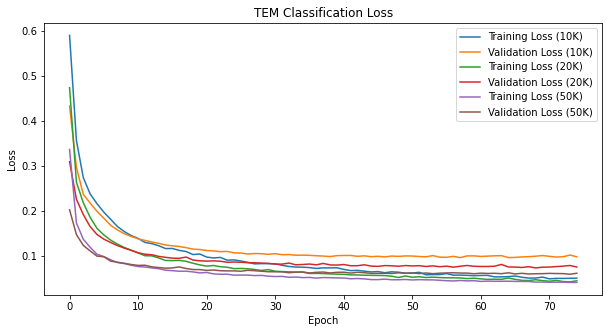

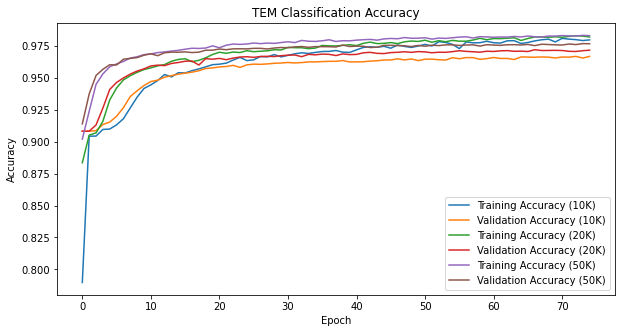

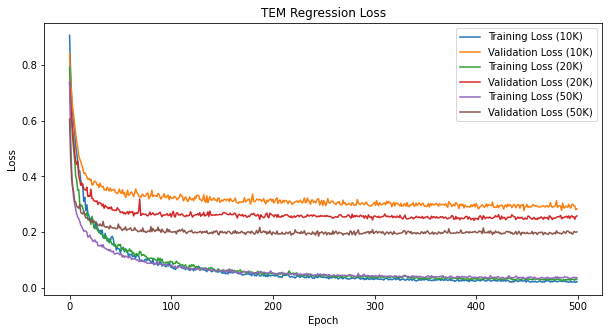

In [110]:
tem_train_loss_50K, tem_train_acc_50K, tem_valid_loss_50K, tem_valid_acc_50K, tem_reg_train_loss_50K, tem_reg_valid_loss_50K = tem_losses_50K

plt.figure(figsize=(10,5))
plt.plot(tem_train_loss, label = "Training Loss (10K)")
plt.plot(tem_valid_loss, label = "Validation Loss (10K)")
plt.plot(tem_train_loss_20K, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K, label = "Validation Loss (20K)")
plt.plot(tem_train_loss_50K, label = "Training Loss (50K)")
plt.plot(tem_valid_loss_50K, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(tem_train_acc, label = "Training Accuracy (10K)")
plt.plot(tem_valid_acc, label = "Validation Accuracy (10K)")
plt.plot(tem_train_acc_20K, label = "Training Accuracy (20K)")
plt.plot(tem_valid_acc_20K, label = "Validation Accuracy (20K)")
plt.plot(tem_train_acc_50K, label = "Training Accuracy (50K)")
plt.plot(tem_valid_acc_50K, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("TEM Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(tem_reg_train_loss, label = "Training Loss (10K)")
plt.plot(tem_reg_valid_loss, label = "Validation Loss (10K)")
plt.plot(tem_reg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K, label = "Validation Loss (20K)")
plt.plot(tem_reg_train_loss_50K, label = "Training Loss (50K)")
plt.plot(tem_reg_valid_loss_50K, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Regression Loss")

In [111]:
# save the models
torch.save(tem_class_50K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_50K.pt")
torch.save(tem_reg_50K.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_50K.pt")

In [113]:
torch.set_default_dtype(torch.float32)

class Classifier_Big(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        X = self.model(x)
        return X

class Regressor_Big(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(64, 1),

        )

    def forward(self, x):
        X = self.model(x.float())
        return X

In [115]:
itg_train_loader_10K_big, itg_valid_loader_10K_big = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_10K,
    validation_data
)

itg_class_10K_big, itg_reg_10K_big, itg_losses_10K_big = train_model(
    itg_train_loader_10K_big,   
    itg_valid_loader_10K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
)



etg_train_loader_10K_big, etg_valid_loader_10K_big = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_10K,
    validation_data
)

etg_class_10K_big, etg_reg_10K_big, etg_losses_10K_big = train_model(
    etg_train_loader_10K_big,
    etg_valid_loader_10K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
    class_epochs = 75,
    reg_epochs = 500,
)


tem_train_loader_10K_big, tem_valid_loader_10K_big = get_loaders(
    "efetem_gb",
    "tem",
    train_data_10K,
    validation_data
)

tem_class_10K_big, tem_reg_10K_big, tem_losses_10K_big = train_model(
    tem_train_loader_10K_big,
    tem_valid_loader_10K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
    class_epochs = 75,
    reg_epochs = 500,
)

Training Classifier
Train Error: 
 Accuracy: 71.0%, Avg loss: 0.630602 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.539761 

Epoch 1/50 

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.473927 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.429430 

Epoch 2/50 

Train Error: 
 Accuracy: 74.8%, Avg loss: 0.397392 

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.379321 

Epoch 3/50 

Train Error: 
 Accuracy: 83.4%, Avg loss: 0.346847 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.332722 

Epoch 4/50 

Train Error: 
 Accuracy: 88.4%, Avg loss: 0.297931 

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.295255 

Epoch 5/50 

Train Error: 
 Accuracy: 89.4%, Avg loss: 0.270695 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.267534 

Epoch 6/50 

Train Error: 
 Accuracy: 90.0%, Avg loss: 0.238335 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.236506 

Epoch 7/50 

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.213290 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.219117 

Epoch 8/50 

Train Error: 
 Accuracy: 91.0%, Avg 

In [117]:
# save the models
torch.save(itg_class_10K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_10K_big.pt")
torch.save(itg_reg_10K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_10K_big.pt")

torch.save(etg_class_10K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_10K_big.pt")
torch.save(etg_reg_10K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_10K_big.pt")

torch.save(tem_class_10K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_10K_big.pt")
torch.save(tem_reg_10K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_10K_big.pt")

In [118]:
itg_train_loader_20K_big, itg_valid_loader_20K_big = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_20K,
    validation_data
)

itg_class_20K_big, itg_reg_20K_big, itg_losses_20K_big = train_model(
    itg_train_loader_20K_big,   
    itg_valid_loader_20K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
)



etg_train_loader_20K_big, etg_valid_loader_20K_big = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_20K,
    validation_data
)

etg_class_20K_big, etg_reg_20K_big, etg_losses_20K_big = train_model(
    etg_train_loader_20K_big,
    etg_valid_loader_20K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
    class_epochs = 75,
    reg_epochs = 500,
)


tem_train_loader_20K_big, tem_valid_loader_20K_big = get_loaders(
    "efetem_gb",
    "tem",
    train_data_20K,
    validation_data
)

tem_class_20K_big, tem_reg_20K_big, tem_losses_20K_big = train_model(
    tem_train_loader_20K_big,
    tem_valid_loader_20K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
    class_epochs = 75,
    reg_epochs = 500,
)

Training Classifier
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.551409 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.431792 

Epoch 1/50 

Train Error: 
 Accuracy: 75.3%, Avg loss: 0.386810 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.336787 

Epoch 2/50 

Train Error: 
 Accuracy: 88.3%, Avg loss: 0.302891 

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.276477 

Epoch 3/50 

Train Error: 
 Accuracy: 89.5%, Avg loss: 0.254819 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.228152 

Epoch 4/50 

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.216032 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.206302 

Epoch 5/50 

Train Error: 
 Accuracy: 91.8%, Avg loss: 0.195342 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.196881 

Epoch 6/50 

Train Error: 
 Accuracy: 92.3%, Avg loss: 0.184233 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.185460 

Epoch 7/50 

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.177636 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.182808 

Epoch 8/50 

Train Error: 
 Accuracy: 92.8%, Avg 

In [119]:
# save the models
torch.save(itg_class_20K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_20K_big.pt")
torch.save(itg_reg_20K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_20K_big.pt")

torch.save(etg_class_20K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_20K_big.pt")
torch.save(etg_reg_20K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_20K_big.pt")

torch.save(tem_class_20K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_20K_big.pt")
torch.save(tem_reg_20K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_20K_big.pt")

In [120]:
itg_train_loader_50K_big, itg_valid_loader_50K_big = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_50K,
    validation_data
)

itg_class_50K_big, itg_reg_50K_big, itg_losses_50K_big = train_model(
    itg_train_loader_50K_big,   
    itg_valid_loader_50K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
)



etg_train_loader_50K_big, etg_valid_loader_50K_big = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_50K,
    validation_data
)

etg_class_50K_big, etg_reg_50K_big, etg_losses_50K_big = train_model(
    etg_train_loader_50K_big,
    etg_valid_loader_50K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
    class_epochs = 75,
    reg_epochs = 500,
)



tem_train_loader_50K_big, tem_valid_loader_50K_big = get_loaders(
    "efetem_gb",
    "tem",
    train_data_50K,
    validation_data
)

tem_class_50K_big, tem_reg_50K_big, tem_losses_50K_big = train_model(
    tem_train_loader_50K_big,
    tem_valid_loader_50K_big,
    classifier = Classifier_Big,
    regressor = Regressor_Big,
    class_epochs = 75,
    reg_epochs = 500,
)

Training Classifier
Train Error: 
 Accuracy: 79.1%, Avg loss: 0.427170 

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.298397 

Epoch 1/50 

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.244410 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.204166 

Epoch 2/50 

Train Error: 
 Accuracy: 92.1%, Avg loss: 0.189150 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.181567 

Epoch 3/50 

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.173209 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.170257 

Epoch 4/50 

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.163399 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.162871 

Epoch 5/50 

Train Error: 
 Accuracy: 93.6%, Avg loss: 0.154450 

Test Error: 
 Accuracy: 93.4%, Avg loss: 0.159177 

Epoch 6/50 

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.148885 

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.151023 

Epoch 7/50 

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.142780 

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.147772 

Epoch 8/50 

Train Error: 
 Accuracy: 94.2%, Avg 

In [125]:
# save the models
torch.save(itg_class_50K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_50K_big.pt")
torch.save(itg_reg_50K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_50K_big.pt")

torch.save(etg_class_50K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_50K_big.pt")
torch.save(etg_reg_50K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_50K_big.pt")

torch.save(tem_class_50K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_50K_big.pt")
torch.save(tem_reg_50K_big.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_50K_big.pt")

Text(0.5, 1.0, 'ITG Regression Loss')

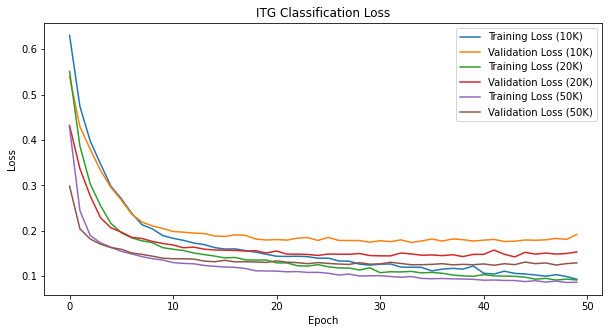

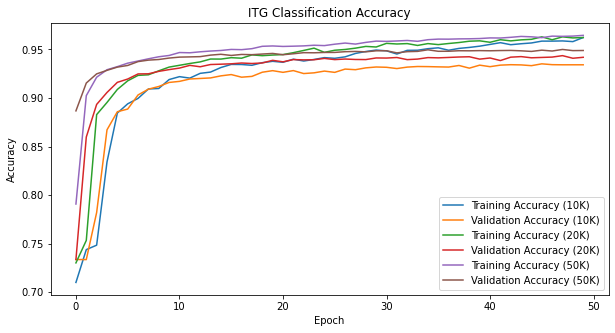

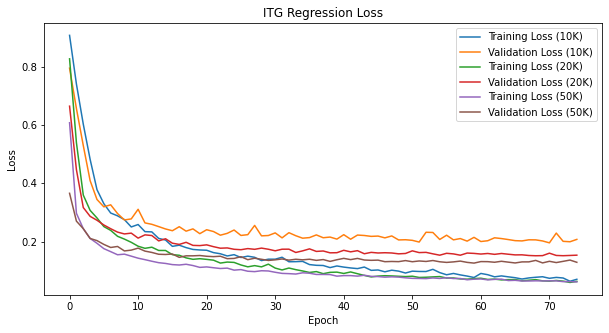

In [122]:
itg_train_loss_10K_big, itg_train_acc_10K_big, itg_valid_loss_10K_big, itg_valid_acc_10K_big, itg_reg_train_loss_10K_big, itg_reg_valid_loss_10K_big = itg_losses_10K_big
itg_train_loss_50K_big, itg_train_acc_50K_big, itg_valid_loss_50K_big, itg_valid_acc_50K_big, itg_reg_train_loss_50K_big, itg_reg_valid_loss_50K_big = itg_losses_50K_big
itg_train_loss_20K_big, itg_train_acc_20K_big, itg_valid_loss_20K_big, itg_valid_acc_20K_big, itg_reg_train_loss_20K_big, itg_reg_valid_loss_20K_big = itg_losses_20K_big

plt.figure(figsize=(10,5))
plt.plot(itg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(itg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(itg_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(itg_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(itg_train_loss_50K_big, label = "Training Loss (50K)")
plt.plot(itg_valid_loss_50K_big, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(itg_train_acc_10K_big, label = "Training Accuracy (10K)")
plt.plot(itg_valid_acc_10K_big, label = "Validation Accuracy (10K)")
plt.plot(itg_train_acc_20K_big, label = "Training Accuracy (20K)")
plt.plot(itg_valid_acc_20K_big, label = "Validation Accuracy (20K)")
plt.plot(itg_train_acc_50K_big, label = "Training Accuracy (50K)")
plt.plot(itg_valid_acc_50K_big, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ITG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(itg_reg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(itg_reg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(itg_reg_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(itg_reg_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(itg_reg_train_loss_50K_big, label = "Training Loss (50K)")
plt.plot(itg_reg_valid_loss_50K_big, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Regression Loss")

Text(0.5, 1.0, 'ETG Regression Loss')

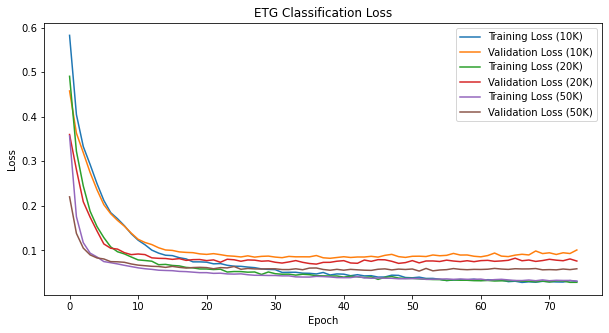

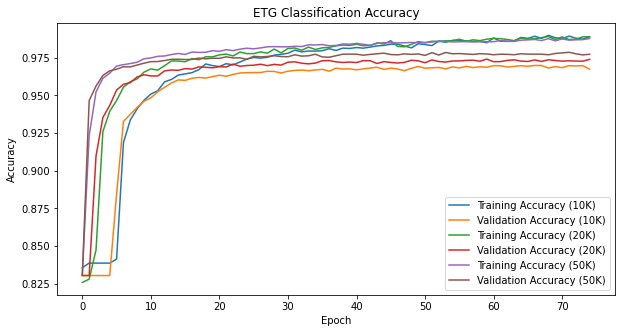

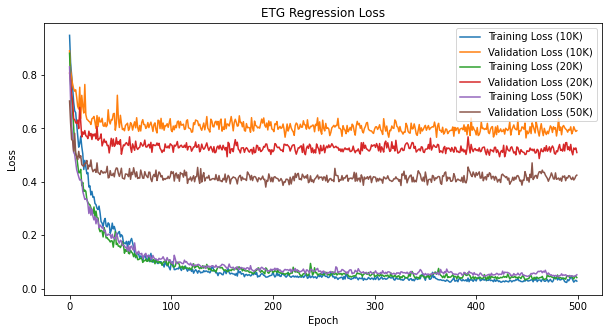

In [123]:
etg_train_loss_10K_big, etg_train_acc_10K_big, etg_valid_loss_10K_big, etg_valid_acc_10K_big, etg_reg_train_loss_10K_big, etg_reg_valid_loss_10K_big = etg_losses_10K_big
etg_train_loss_50K_big, etg_train_acc_50K_big, etg_valid_loss_50K_big, etg_valid_acc_50K_big, etg_reg_train_loss_50K_big, etg_reg_valid_loss_50K_big = etg_losses_50K_big
etg_train_loss_20K_big, etg_train_acc_20K_big, etg_valid_loss_20K_big, etg_valid_acc_20K_big, etg_reg_train_loss_20K_big, etg_reg_valid_loss_20K_big = etg_losses_20K_big

plt.figure(figsize=(10,5))
plt.plot(etg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(etg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(etg_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(etg_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(etg_train_loss_50K_big, label = "Training Loss (50K)")
plt.plot(etg_valid_loss_50K_big, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc_10K_big, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc_10K_big, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc_20K_big, label = "Training Accuracy (20K)")
plt.plot(etg_valid_acc_20K_big, label = "Validation Accuracy (20K)")
plt.plot(etg_train_acc_50K_big, label = "Training Accuracy (50K)")
plt.plot(etg_valid_acc_50K_big, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ETG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(etg_reg_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(etg_reg_train_loss_50K_big, label = "Training Loss (50K)")
plt.plot(etg_reg_valid_loss_50K_big, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")

Text(0.5, 1.0, 'TEM Regression Loss')

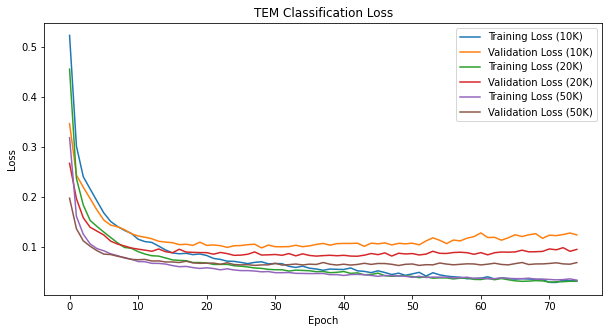

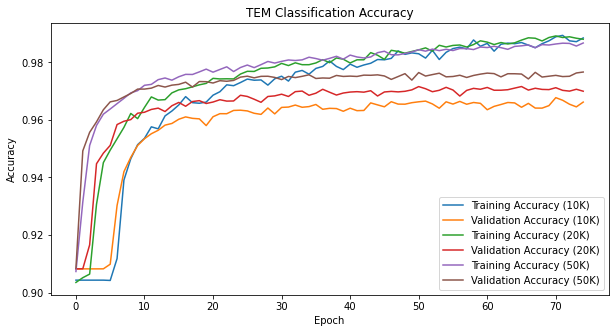

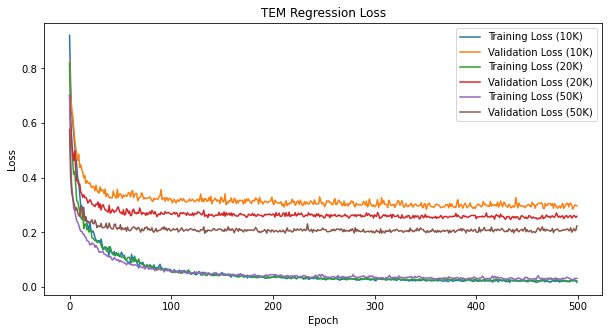

In [124]:
tem_train_loss_10K_big, tem_train_acc_10K_big, tem_valid_loss_10K_big, tem_valid_acc_10K_big, tem_reg_train_loss_10K_big, tem_reg_valid_loss_10K_big = tem_losses_10K_big
tem_train_loss_50K_big, tem_train_acc_50K_big, tem_valid_loss_50K_big, tem_valid_acc_50K_big, tem_reg_train_loss_50K_big, tem_reg_valid_loss_50K_big = tem_losses_50K_big
tem_train_loss_20K_big, tem_train_acc_20K_big, tem_valid_loss_20K_big, tem_valid_acc_20K_big, tem_reg_train_loss_20K_big, tem_reg_valid_loss_20K_big = tem_losses_20K_big

plt.figure(figsize=(10,5))
plt.plot(tem_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(tem_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(tem_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(tem_train_loss_50K_big, label = "Training Loss (50K)")
plt.plot(tem_valid_loss_50K_big, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(tem_train_acc_10K_big, label = "Training Accuracy (10K)")
plt.plot(tem_valid_acc_10K_big, label = "Validation Accuracy (10K)")
plt.plot(tem_train_acc_20K_big, label = "Training Accuracy (20K)")
plt.plot(tem_valid_acc_20K_big, label = "Validation Accuracy (20K)")
plt.plot(tem_train_acc_50K_big, label = "Training Accuracy (50K)")
plt.plot(tem_valid_acc_50K_big, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("TEM Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(tem_reg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(tem_reg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(tem_reg_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(tem_reg_train_loss_50K_big, label = "Training Loss (50K)")
plt.plot(tem_reg_valid_loss_50K_big, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Regression Loss")

In [126]:
torch.set_default_dtype(torch.float32)

class Classifier_Bigger(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        X = self.model(x)
        return X

class Regressor_Bigger(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(15, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(64, 1),

        )

    def forward(self, x):
        X = self.model(x.float())
        return X

In [128]:
itg_train_loader_10K_bigger, itg_valid_loader_10K_bigger = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_10K,
    validation_data
)

itg_class_10K_bigger, itg_reg_10K_bigger, itg_losses_10K_bigger = train_model(
    itg_train_loader_10K_bigger,   
    itg_valid_loader_10K_big,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
)



etg_train_loader_10K_bigger, etg_valid_loader_10K_bigger = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_10K,
    validation_data
)

etg_class_10K_bigger, etg_reg_10K_bigger, etg_losses_10K_bigger = train_model(
    etg_train_loader_10K_bigger,
    etg_valid_loader_10K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
    class_epochs = 75,
    reg_epochs = 150,
)


tem_train_loader_10K_bigger, tem_valid_loader_10K_bigger = get_loaders(
    "efetem_gb",
    "tem",
    train_data_10K,
    validation_data
)

tem_class_10K_bigger, tem_reg_10K_bigger, tem_losses_10K_bigger = train_model(
    tem_train_loader_10K_bigger,
    tem_valid_loader_10K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
    class_epochs = 75,
    reg_epochs = 150,
)

Training Classifier
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.630286 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.549689 

Epoch 1/50 

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.487280 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.434657 

Epoch 2/50 

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.397449 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.380811 

Epoch 3/50 

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.350139 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.338094 

Epoch 4/50 

Train Error: 
 Accuracy: 74.3%, Avg loss: 0.322948 

Test Error: 
 Accuracy: 77.3%, Avg loss: 0.324069 

Epoch 5/50 

Train Error: 
 Accuracy: 86.5%, Avg loss: 0.299357 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.305943 

Epoch 6/50 

Train Error: 
 Accuracy: 89.2%, Avg loss: 0.276751 

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.284935 

Epoch 7/50 

Train Error: 
 Accuracy: 89.8%, Avg loss: 0.252673 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.253746 

Epoch 8/50 

Train Error: 
 Accuracy: 90.3%, Avg 

In [136]:
# save the models
torch.save(itg_class_10K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_10K_bigger.pt")
torch.save(itg_reg_10K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_10K_bigger.pt")

torch.save(etg_class_10K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_10K_bigger.pt")
torch.save(etg_reg_10K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_10K_bigger.pt")

torch.save(tem_class_10K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_10K_bigger.pt")
torch.save(tem_reg_10K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_10K_bigger.pt")

In [129]:
itg_train_loader_20K_bigger, itg_valid_loader_20K_bigger = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_20K,
    validation_data
)

itg_class_20K_bigger, itg_reg_20K_bigger, itg_losses_20K_bigger = train_model(
    itg_train_loader_20K_bigger,   
    itg_valid_loader_20K_big,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
)



etg_train_loader_20K_bigger, etg_valid_loader_20K_bigger = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_20K,
    validation_data
)

etg_class_20K_bigger, etg_reg_20K_bigger, etg_losses_20K_bigger = train_model(
    etg_train_loader_20K_bigger,
    etg_valid_loader_20K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
    class_epochs = 75,
    reg_epochs = 150,
)


tem_train_loader_20K_bigger, tem_valid_loader_20K_bigger = get_loaders(
    "efetem_gb",
    "tem",
    train_data_20K,
    validation_data
)

tem_class_20K_bigger, tem_reg_20K_bigger, tem_losses_20K_bigger = train_model(
    tem_train_loader_20K_bigger,
    tem_valid_loader_20K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
    class_epochs = 75,
    reg_epochs = 150,
)

Training Classifier
Train Error: 
 Accuracy: 63.9%, Avg loss: 0.587240 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.450623 

Epoch 1/50 

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.397221 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.338502 

Epoch 2/50 

Train Error: 
 Accuracy: 87.9%, Avg loss: 0.316142 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.302119 

Epoch 3/50 

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.287125 

Test Error: 
 Accuracy: 89.7%, Avg loss: 0.268154 

Epoch 4/50 

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.240519 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.216767 

Epoch 5/50 

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.203552 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.194035 

Epoch 6/50 

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.184126 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.187146 

Epoch 7/50 

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.174175 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.177651 

Epoch 8/50 

Train Error: 
 Accuracy: 93.0%, Avg 

In [130]:
# save the models
torch.save(itg_class_20K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_20K_bigger.pt")
torch.save(itg_reg_20K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_20K_bigger.pt")
torch.save(etg_class_20K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_20K_bigger.pt")
torch.save(etg_reg_20K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_20K_bigger.pt")
torch.save(tem_class_20K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_20K_bigger.pt")
torch.save(tem_reg_20K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_20K_bigger.pt")

In [131]:
# repeat for 50K
itg_train_loader_50K_bigger, itg_valid_loader_50K_bigger = get_loaders(
    "efiitg_gb",
    "itg",
    train_data_50K,
    validation_data
)

itg_class_50K_bigger, itg_reg_50K_bigger, itg_losses_50K_bigger = train_model(
    itg_train_loader_50K_bigger,
    itg_valid_loader_50K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
)

etg_train_loader_50K_bigger, etg_valid_loader_50K_bigger = get_loaders(
    "efeetg_gb",
    "etg",
    train_data_50K,
    validation_data
)

etg_class_50K_bigger, etg_reg_50K_bigger, etg_losses_50K_bigger = train_model(
    etg_train_loader_50K_bigger,
    etg_valid_loader_50K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
    class_epochs = 75,
    reg_epochs = 150,
)

tem_train_loader_50K_bigger, tem_valid_loader_50K_bigger = get_loaders(
    "efetem_gb",
    "tem",
    train_data_50K,
    validation_data
)

tem_class_50K_bigger, tem_reg_50K_bigger, tem_losses_50K_bigger = train_model(
    tem_train_loader_50K_bigger,
    tem_valid_loader_50K_bigger,
    classifier = Classifier_Bigger,
    regressor = Regressor_Bigger,
    class_epochs = 75,
    reg_epochs = 150,
)


Training Classifier
Train Error: 
 Accuracy: 73.0%, Avg loss: 0.457015 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.325773 

Epoch 1/50 

Train Error: 
 Accuracy: 89.1%, Avg loss: 0.267223 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.207963 

Epoch 2/50 

Train Error: 
 Accuracy: 92.2%, Avg loss: 0.188217 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.179846 

Epoch 3/50 

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.170478 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.164068 

Epoch 4/50 

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.160446 

Test Error: 
 Accuracy: 93.4%, Avg loss: 0.159073 

Epoch 5/50 

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.150554 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.158085 

Epoch 6/50 

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.146258 

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.150744 

Epoch 7/50 

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.141446 

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.143929 

Epoch 8/50 

Train Error: 
 Accuracy: 94.3%, Avg 

In [132]:
# save the models
torch.save(itg_class_50K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_class_50K_bigger.pt")
torch.save(itg_reg_50K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/itg_reg_50K_bigger.pt")

torch.save(etg_class_50K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_class_50K_bigger.pt")
torch.save(etg_reg_50K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/etg_reg_50K_bigger.pt")

torch.save(tem_class_50K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_class_50K_bigger.pt")
torch.save(tem_reg_50K_bigger.state_dict(), "/unix/atlastracking/jbarr/UKAEAGroupProject/models/tem_reg_50K_bigger.pt")

Text(0.5, 1.0, 'ITG Regression Loss')

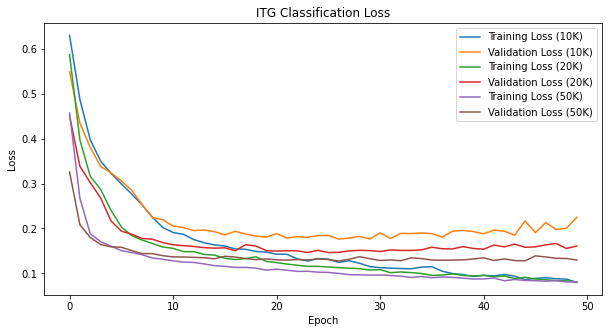

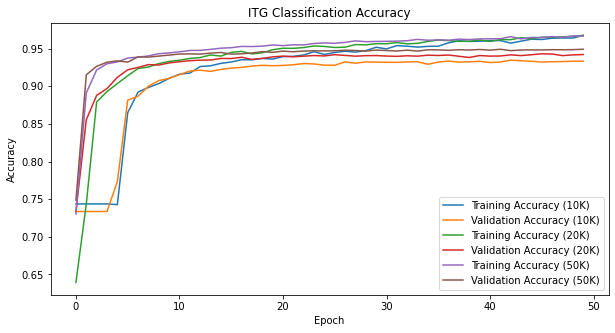

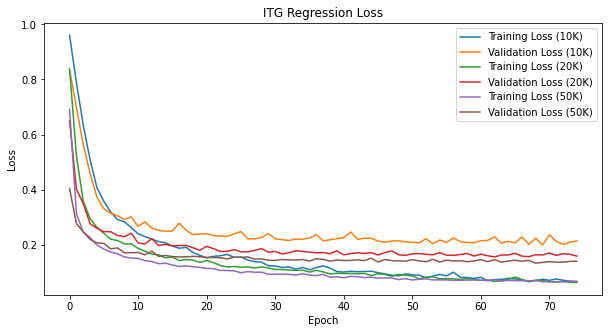

In [137]:
itg_train_loss_10K_bigger, itg_train_acc_10K_bigger, itg_valid_loss_10K_bigger, itg_valid_acc_10K_bigger, itg_reg_train_loss_10K_bigger, itg_reg_valid_loss_10K_bigger = itg_losses_10K_bigger
itg_train_loss_50K_bigger, itg_train_acc_50K_bigger, itg_valid_loss_50K_bigger, itg_valid_acc_50K_bigger, itg_reg_train_loss_50K_bigger, itg_reg_valid_loss_50K_bigger = itg_losses_50K_bigger
itg_train_loss_20K_bigger, itg_train_acc_20K_bigger, itg_valid_loss_20K_bigger, itg_valid_acc_20K_bigger, itg_reg_train_loss_20K_bigger, itg_reg_valid_loss_20K_bigger = itg_losses_20K_bigger

plt.figure(figsize=(10,5))
plt.plot(itg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(itg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(itg_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(itg_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(itg_train_loss_50K_bigger, label = "Training Loss (50K)")
plt.plot(itg_valid_loss_50K_bigger, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(itg_train_acc_10K_bigger, label = "Training Accuracy (10K)")
plt.plot(itg_valid_acc_10K_bigger, label = "Validation Accuracy (10K)")
plt.plot(itg_train_acc_20K_bigger, label = "Training Accuracy (20K)")
plt.plot(itg_valid_acc_20K_bigger, label = "Validation Accuracy (20K)")
plt.plot(itg_train_acc_50K_bigger, label = "Training Accuracy (50K)")
plt.plot(itg_valid_acc_50K_bigger, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ITG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(itg_reg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(itg_reg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(itg_reg_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(itg_reg_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(itg_reg_train_loss_50K_bigger, label = "Training Loss (50K)")
plt.plot(itg_reg_valid_loss_50K_bigger, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ITG Regression Loss")

Text(0.5, 1.0, 'ETG Regression Loss')

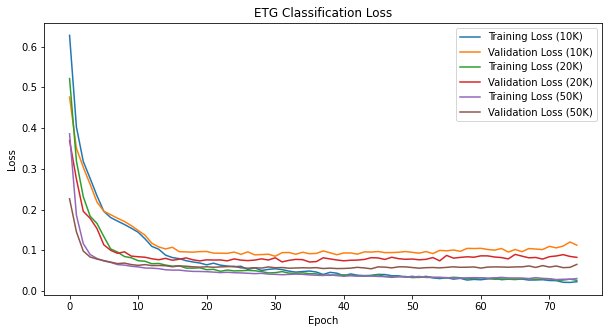

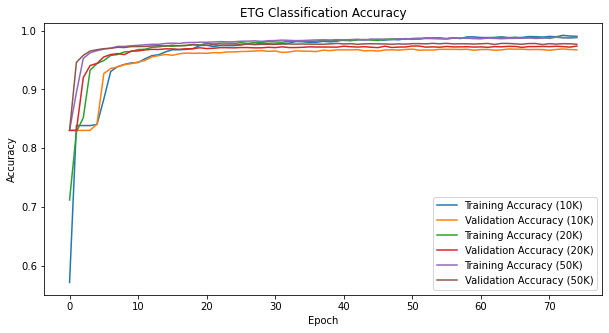

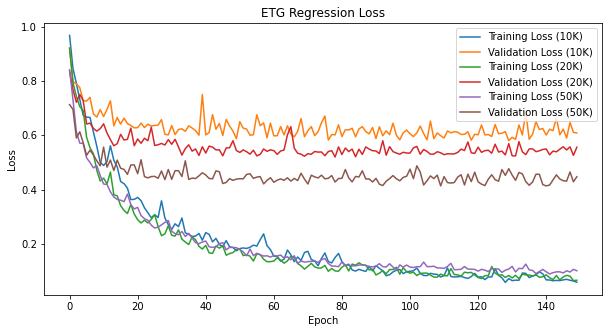

In [138]:
etg_train_loss_10K_bigger, etg_train_acc_10K_bigger, etg_valid_loss_10K_bigger, etg_valid_acc_10K_bigger, etg_reg_train_loss_10K_bigger, etg_reg_valid_loss_10K_bigger = etg_losses_10K_bigger
etg_train_loss_50K_bigger, etg_train_acc_50K_bigger, etg_valid_loss_50K_bigger, etg_valid_acc_50K_bigger, etg_reg_train_loss_50K_bigger, etg_reg_valid_loss_50K_bigger = etg_losses_50K_bigger
etg_train_loss_20K_bigger, etg_train_acc_20K_bigger, etg_valid_loss_20K_bigger, etg_valid_acc_20K_bigger, etg_reg_train_loss_20K_bigger, etg_reg_valid_loss_20K_bigger = etg_losses_20K_bigger

plt.figure(figsize=(10,5))
plt.plot(etg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(etg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(etg_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(etg_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(etg_train_loss_50K_bigger, label = "Training Loss (50K)")
plt.plot(etg_valid_loss_50K_bigger, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc_10K_bigger, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc_10K_bigger, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc_20K_bigger, label = "Training Accuracy (20K)")
plt.plot(etg_valid_acc_20K_bigger, label = "Validation Accuracy (20K)")
plt.plot(etg_train_acc_50K_bigger, label = "Training Accuracy (50K)")
plt.plot(etg_valid_acc_50K_bigger, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ETG Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(etg_reg_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(etg_reg_train_loss_50K_bigger, label = "Training Loss (50K)")
plt.plot(etg_reg_valid_loss_50K_bigger, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")

Text(0.5, 1.0, 'TEM Regression Loss')

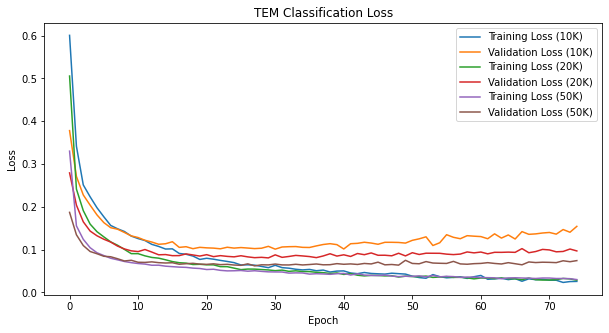

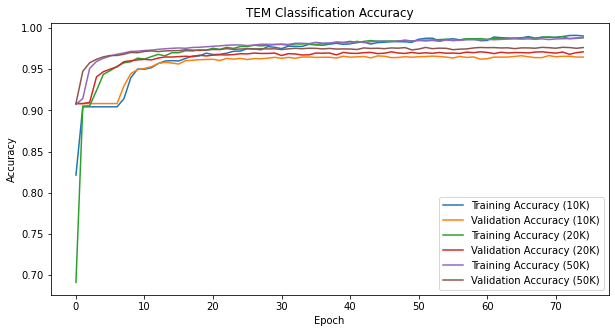

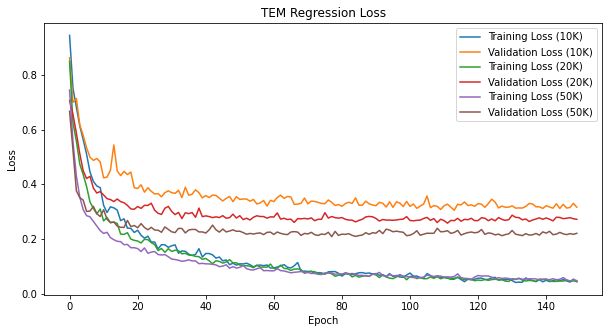

In [139]:
tem_train_loss_10K_bigger, tem_train_acc_10K_bigger, tem_valid_loss_10K_bigger, tem_valid_acc_10K_bigger, tem_reg_train_loss_10K_bigger, tem_reg_valid_loss_10K_bigger = tem_losses_10K_bigger
tem_train_loss_50K_bigger, tem_train_acc_50K_bigger, tem_valid_loss_50K_bigger, tem_valid_acc_50K_bigger, tem_reg_train_loss_50K_bigger, tem_reg_valid_loss_50K_bigger = tem_losses_50K_bigger
tem_train_loss_20K_bigger, tem_train_acc_20K_bigger, tem_valid_loss_20K_bigger, tem_valid_acc_20K_bigger, tem_reg_train_loss_20K_bigger, tem_reg_valid_loss_20K_bigger = tem_losses_20K_bigger

plt.figure(figsize=(10,5))
plt.plot(tem_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(tem_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(tem_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(tem_train_loss_50K_bigger, label = "Training Loss (50K)")
plt.plot(tem_valid_loss_50K_bigger, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Classification Loss")

plt.figure(figsize=(10, 5))
plt.plot(tem_train_acc_10K_bigger, label = "Training Accuracy (10K)")
plt.plot(tem_valid_acc_10K_bigger, label = "Validation Accuracy (10K)")
plt.plot(tem_train_acc_20K_bigger, label = "Training Accuracy (20K)")
plt.plot(tem_valid_acc_20K_bigger, label = "Validation Accuracy (20K)")
plt.plot(tem_train_acc_50K_bigger, label = "Training Accuracy (50K)")
plt.plot(tem_valid_acc_50K_bigger, label = "Validation Accuracy (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("TEM Classification Accuracy")

plt.figure(figsize=(10, 5))
plt.plot(tem_reg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(tem_reg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(tem_reg_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(tem_reg_train_loss_50K_bigger, label = "Training Loss (50K)")
plt.plot(tem_reg_valid_loss_50K_bigger, label = "Validation Loss (50K)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Regression Loss")

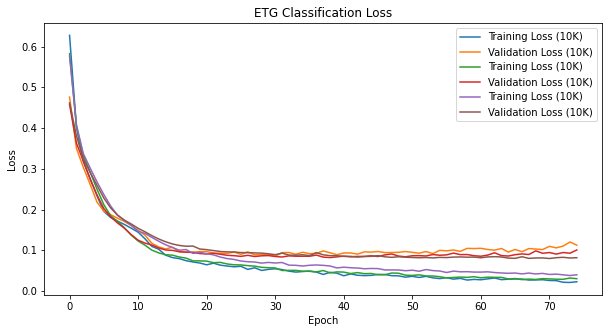

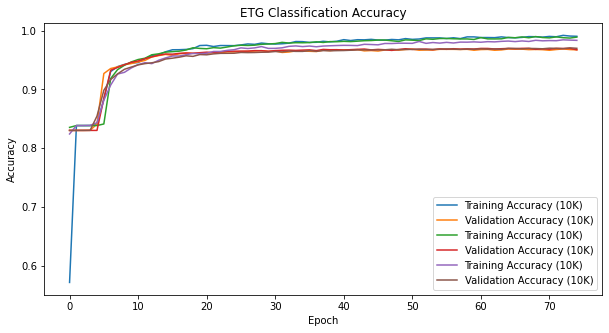

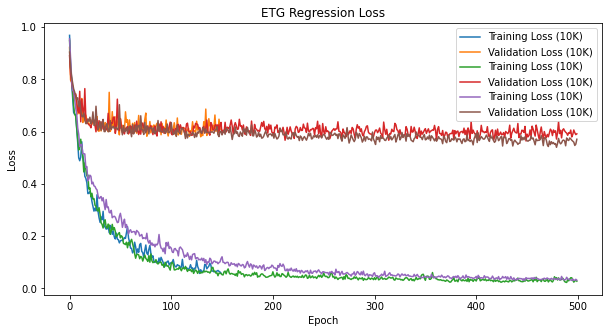

In [141]:
# plot comparison of different models
plt.figure(figsize=(10, 5))
plt.plot(etg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(etg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(etg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(etg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(etg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_valid_loss, label = "Validation Loss (10K)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc_10K_bigger, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc_10K_bigger, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc_10K_big, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc_10K_big, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc, label = "Validation Accuracy (10K)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ETG Classification Accuracy")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss, label = "Validation Loss (10K)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")
plt.legend()


In [ ]:
# plot comparison of different models
plt.figure(figsize=(10, 5))
plt.plot(etg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(etg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(etg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(etg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(etg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_valid_loss, label = "Validation Loss (10K)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Classification Loss")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(etg_train_acc_10K_bigger, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc_10K_bigger, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc_10K_big, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc_10K_big, label = "Validation Accuracy (10K)")
plt.plot(etg_train_acc, label = "Training Accuracy (10K)")
plt.plot(etg_valid_acc, label = "Validation Accuracy (10K)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ETG Classification Accuracy")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(etg_reg_train_loss_10K_bigger, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss_10K_bigger, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss_10K_big, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss_10K_big, label = "Validation Loss (10K)")
plt.plot(etg_reg_train_loss, label = "Training Loss (10K)")
plt.plot(etg_reg_valid_loss, label = "Validation Loss (10K)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ETG Regression Loss")
plt.legend()


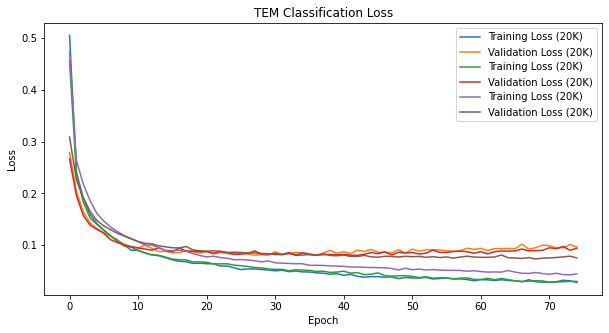

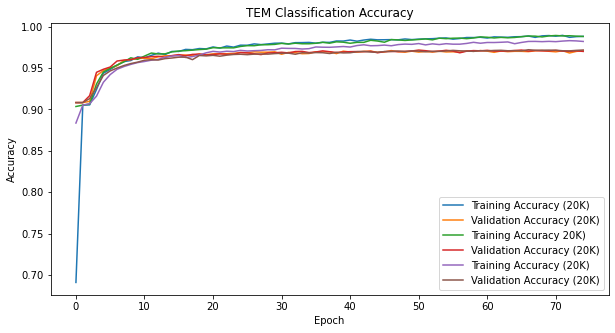

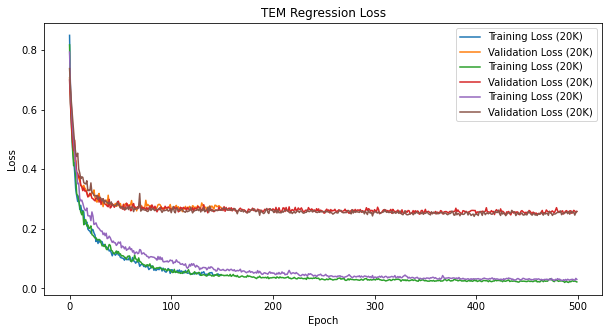

In [144]:
# plot comparison of different models
plt.figure(figsize=(10, 5))
plt.plot(tem_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(tem_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(tem_train_loss_20K, label = "Training Loss (20K)")
plt.plot(tem_valid_loss_20K, label = "Validation Loss (20K)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Classification Loss")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(tem_train_acc_20K_bigger, label = "Training Accuracy (20K)")
plt.plot(tem_valid_acc_20K_bigger, label = "Validation Accuracy (20K)")
plt.plot(tem_train_acc_20K_big, label = "Training Accuracy 20K)")
plt.plot(tem_valid_acc_20K_big, label = "Validation Accuracy (20K)")
plt.plot(tem_train_acc_20K, label = "Training Accuracy (20K)")
plt.plot(tem_valid_acc_20K, label = "Validation Accuracy (20K)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("TEM Classification Accuracy")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(tem_reg_train_loss_20K_bigger, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K_bigger, label = "Validation Loss (20K)")
plt.plot(tem_reg_train_loss_20K_big, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K_big, label = "Validation Loss (20K)")
plt.plot(tem_reg_train_loss_20K, label = "Training Loss (20K)")
plt.plot(tem_reg_valid_loss_20K, label = "Validation Loss (20K)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TEM Regression Loss")
plt.legend()


## Regressor MSE against input size

In [10]:
train_data_10K = train_data.sample(10_000)
train_data_20K = train_data.sample(20_000)
train_data_50K = train_data.sample(50_000)
train_data_100K = train_data.sample(100_000)
train_data_1m = train_data.sample(1_000_000)

In [17]:
itg_train_loader_10K, itg_valid_loader_10K = get_loaders(
    "efiitg_gb", 
    "itg", 
    train_data_10K, 
    validation_data 
)

_, itg_reg_10K, itg_losses = train_model(itg_train_loader_10K, itg_valid_loader_10K, regressor_only = True)

Training Regressor
Train Error: 
Avg loss: 0.904926
Test Error: 
Avg loss: 0.768746 

Epoch 1/75 

Train Error: 
Avg loss: 0.756134
Test Error: 
Avg loss: 0.687536 

Epoch 2/75 

Train Error: 
Avg loss: 0.664984
Test Error: 
Avg loss: 0.595926 

Epoch 3/75 

Train Error: 
Avg loss: 0.574872
Test Error: 
Avg loss: 0.522162 

Epoch 4/75 

Train Error: 
Avg loss: 0.501765
Test Error: 
Avg loss: 0.455832 

Epoch 5/75 

Train Error: 
Avg loss: 0.427326
Test Error: 
Avg loss: 0.414467 

Epoch 6/75 

Train Error: 
Avg loss: 0.383766
Test Error: 
Avg loss: 0.362134 

Epoch 7/75 

Train Error: 
Avg loss: 0.347413
Test Error: 
Avg loss: 0.342982 

Epoch 8/75 

Train Error: 
Avg loss: 0.309350
Test Error: 
Avg loss: 0.304061 

Epoch 9/75 

Train Error: 
Avg loss: 0.286901
Test Error: 
Avg loss: 0.292344 

Epoch 10/75 

Train Error: 
Avg loss: 0.275076
Test Error: 
Avg loss: 0.283476 

Epoch 11/75 

Train Error: 
Avg loss: 0.259426
Test Error: 
Avg loss: 0.272820 

Epoch 12/75 

Train Error: 
Avg 

In [44]:
itg_train_loader_20K, itg_valid_loader_20K = get_loaders(
    "efiitg_gb", 
    "itg", 
    train_data_20K, 
    validation_data 
)

_, itg_reg_20K, itg_losses_20K = train_model(itg_train_loader_20K,
                                             itg_valid_loader_20K,
                                             regressor_only = True,
                                             reg_epochs = 150)

Training Regressor
Train Error: 
Avg loss: 0.847506
Test Error: 
Avg loss: 0.716869 

Epoch 1/150 

Train Error: 
Avg loss: 0.648323
Test Error: 
Avg loss: 0.557828 

Epoch 2/150 

Train Error: 
Avg loss: 0.483783
Test Error: 
Avg loss: 0.423401 

Epoch 3/150 

Train Error: 
Avg loss: 0.360223
Test Error: 
Avg loss: 0.341421 

Epoch 4/150 

Train Error: 
Avg loss: 0.304990
Test Error: 
Avg loss: 0.304500 

Epoch 5/150 

Train Error: 
Avg loss: 0.273309
Test Error: 
Avg loss: 0.282459 

Epoch 6/150 

Train Error: 
Avg loss: 0.254940
Test Error: 
Avg loss: 0.263938 

Epoch 7/150 

Train Error: 
Avg loss: 0.229728
Test Error: 
Avg loss: 0.256003 

Epoch 8/150 

Train Error: 
Avg loss: 0.221260
Test Error: 
Avg loss: 0.245543 

Epoch 9/150 

Train Error: 
Avg loss: 0.214053
Test Error: 
Avg loss: 0.249792 

Epoch 10/150 

Train Error: 
Avg loss: 0.199959
Test Error: 
Avg loss: 0.229580 

Epoch 11/150 

Train Error: 
Avg loss: 0.192612
Test Error: 
Avg loss: 0.232755 

Epoch 12/150 

Train 

Train Error: 
Avg loss: 0.070114
Test Error: 
Avg loss: 0.155304 

Epoch 101/150 

Train Error: 
Avg loss: 0.068781
Test Error: 
Avg loss: 0.161818 

Epoch 102/150 

Train Error: 
Avg loss: 0.066988
Test Error: 
Avg loss: 0.155396 

Epoch 103/150 

Train Error: 
Avg loss: 0.063316
Test Error: 
Avg loss: 0.158797 

Epoch 104/150 

Train Error: 
Avg loss: 0.063626
Test Error: 
Avg loss: 0.154293 

Epoch 105/150 

Train Error: 
Avg loss: 0.064576
Test Error: 
Avg loss: 0.161348 

Epoch 106/150 

Train Error: 
Avg loss: 0.068855
Test Error: 
Avg loss: 0.160401 

Epoch 107/150 

Train Error: 
Avg loss: 0.068267
Test Error: 
Avg loss: 0.156385 

Epoch 108/150 

Train Error: 
Avg loss: 0.070461
Test Error: 
Avg loss: 0.155353 

Epoch 109/150 

Train Error: 
Avg loss: 0.064868
Test Error: 
Avg loss: 0.157356 

Epoch 110/150 

Train Error: 
Avg loss: 0.065130
Test Error: 
Avg loss: 0.156423 

Epoch 111/150 

Train Error: 
Avg loss: 0.062523
Test Error: 
Avg loss: 0.159490 

Epoch 112/150 

Trai

In [22]:
itg_train_loader_50K, itg_valid_loader_50K = get_loaders(
    "efiitg_gb", 
    "itg", 
    train_data_50K, 
    validation_data 
)

_, itg_reg_50K, itg_losses_50K = train_model(itg_train_loader_50K,
                                             itg_valid_loader_50K,
                                             regressor_only = True,
                                             reg_epochs = 50)

Training Regressor
Train Error: 
Avg loss: 0.723336
Test Error: 
Avg loss: 0.523855 

Epoch 1/50 

Train Error: 
Avg loss: 0.379833
Test Error: 
Avg loss: 0.315596 

Epoch 2/50 

Train Error: 
Avg loss: 0.273364
Test Error: 
Avg loss: 0.265843 

Epoch 3/50 

Train Error: 
Avg loss: 0.239916
Test Error: 
Avg loss: 0.242248 

Epoch 4/50 

Train Error: 
Avg loss: 0.221383
Test Error: 
Avg loss: 0.229359 

Epoch 5/50 

Train Error: 
Avg loss: 0.208187
Test Error: 
Avg loss: 0.218748 

Epoch 6/50 

Train Error: 
Avg loss: 0.194124
Test Error: 
Avg loss: 0.204225 

Epoch 7/50 

Train Error: 
Avg loss: 0.183220
Test Error: 
Avg loss: 0.197635 

Epoch 8/50 

Train Error: 
Avg loss: 0.176385
Test Error: 
Avg loss: 0.195767 

Epoch 9/50 

Train Error: 
Avg loss: 0.170844
Test Error: 
Avg loss: 0.181721 

Epoch 10/50 

Train Error: 
Avg loss: 0.163375
Test Error: 
Avg loss: 0.181964 

Epoch 11/50 

Train Error: 
Avg loss: 0.162794
Test Error: 
Avg loss: 0.175023 

Epoch 12/50 

Train Error: 
Avg 

In [23]:
itg_train_loader_100K, itg_valid_loader_100K = get_loaders(
    "efiitg_gb", 
    "itg", 
    train_data_50K, 
    validation_data 
)

_, itg_reg_100K, itg_losses_100K = train_model(itg_train_loader_100K,
                                               itg_valid_loader_100K,
                                               regressor_only = True,
                                               reg_epochs = 50)

Training Regressor
Train Error: 
Avg loss: 0.721129
Test Error: 
Avg loss: 0.510187 

Epoch 1/50 

Train Error: 
Avg loss: 0.376823
Test Error: 
Avg loss: 0.330778 

Epoch 2/50 

Train Error: 
Avg loss: 0.285470
Test Error: 
Avg loss: 0.274395 

Epoch 3/50 

Train Error: 
Avg loss: 0.247133
Test Error: 
Avg loss: 0.242920 

Epoch 4/50 

Train Error: 
Avg loss: 0.225582
Test Error: 
Avg loss: 0.227434 

Epoch 5/50 

Train Error: 
Avg loss: 0.213953
Test Error: 
Avg loss: 0.220133 

Epoch 6/50 

Train Error: 
Avg loss: 0.198681
Test Error: 
Avg loss: 0.209399 

Epoch 7/50 

Train Error: 
Avg loss: 0.192386
Test Error: 
Avg loss: 0.197250 

Epoch 8/50 

Train Error: 
Avg loss: 0.182478
Test Error: 
Avg loss: 0.192382 

Epoch 9/50 

Train Error: 
Avg loss: 0.173979
Test Error: 
Avg loss: 0.192051 

Epoch 10/50 

Train Error: 
Avg loss: 0.168992
Test Error: 
Avg loss: 0.183356 

Epoch 11/50 

Train Error: 
Avg loss: 0.163142
Test Error: 
Avg loss: 0.181255 

Epoch 12/50 

Train Error: 
Avg 

In [24]:
itg_train_loader_1m, itg_valid_loader_1m = get_loaders(
    "efiitg_gb", 
    "itg", 
    train_data_1m, 
    validation_data 
)

_, itg_reg_1m, itg_losses_1m = train_model(itg_train_loader_1m,
                                           itg_valid_loader_1m,
                                           regressor_only = True,
                                           reg_epochs = 50)

Training Regressor
Train Error: 
Avg loss: 0.211459
Test Error: 
Avg loss: 0.147559 

Epoch 1/50 

Train Error: 
Avg loss: 0.131215
Test Error: 
Avg loss: 0.128653 

Epoch 2/50 

Train Error: 
Avg loss: 0.116746
Test Error: 
Avg loss: 0.113289 

Epoch 3/50 

Train Error: 
Avg loss: 0.109365
Test Error: 
Avg loss: 0.105675 

Epoch 4/50 

Train Error: 
Avg loss: 0.104514
Test Error: 
Avg loss: 0.103952 

Epoch 5/50 

Train Error: 
Avg loss: 0.101090
Test Error: 
Avg loss: 0.100840 

Epoch 6/50 

Train Error: 
Avg loss: 0.098589
Test Error: 
Avg loss: 0.102412 

Epoch 7/50 

Train Error: 
Avg loss: 0.096307
Test Error: 
Avg loss: 0.094091 

Epoch 8/50 

Train Error: 
Avg loss: 0.094937
Test Error: 
Avg loss: 0.094806 

Epoch 9/50 

Train Error: 
Avg loss: 0.093200
Test Error: 
Avg loss: 0.098518 

Epoch 10/50 

Train Error: 
Avg loss: 0.091588
Test Error: 
Avg loss: 0.092014 

Epoch 11/50 

Train Error: 
Avg loss: 0.091005
Test Error: 
Avg loss: 0.092774 

Epoch 12/50 

Train Error: 
Avg 

In [ ]:
# itg_train_loader_full, itg_valid_loader_full = get_loaders(
#     "efiitg_gb", 
#     "itg", 
#     train_data_full, 
#     validation_data 
# )

# _, itg_reg_full, itg_losses_full = train_model(itg_train_loader_full,
#                                            itg_valid_loader_full,
#                                            regressor_only = True,
#                                            reg_epochs = 50)

In [25]:
def get_mse(y_hat, y):
    mse = np.mean((y - y_hat) ** 2)
    return mse

In [45]:
vals = []

vals.append(itg_losses[-1][-1])
vals.append(itg_losses_20K[-1][-1])
vals.append(itg_losses_50K[-1][-1])
vals.append(itg_losses_100K[-1][-1])
vals.append(itg_losses_1m[-1][-1])
vals.append(0.0565)

In [42]:
sizes = (10_000, 20_000, 50_000, 100_000, 1_000_000, 17_000_000)

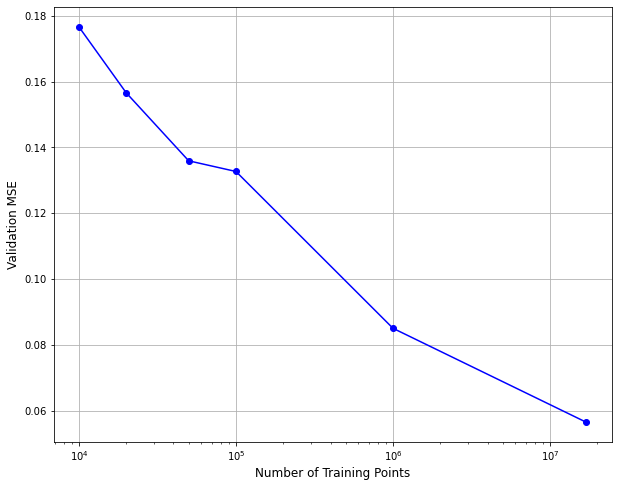

In [46]:
plt.figure(figsize = (10,8))
plt.plot(sizes, vals, "o-", color = "blue")
plt.grid()
plt.xscale("log")
plt.xlabel("Number of Training Points", fontsize = 12)
plt.ylabel("Validation MSE", fontsize = 12)
plt.savefig("ValidationMSE", dpi = 300)